## Title :
MCMC and PyMC3 Hierarchical Models

## Description :
Download this notebook on your local environment. Some parts of it are time-consuming, so we are providing the output cells as well. Once you have gone through them, make changes and run the cells again.

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lecture 13 - MCMC and Hierarchical Models in PyMC3 

**Harvard University**<br>
**Spring 2021**<br>
**Instructors:** Pavlos Protopapas, Mark Glickman, and Chris Tanner<br>
**Additional Instructor:** Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [8]:
import pymc as pm
from pymc import summary
import arviz as az
from matplotlib import gridspec
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings
messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

# or silence all warnings (not recommended)
# warnings.filterwarnings('ignore')

for m in messages:
    warnings.filterwarnings("ignore", message=m)
print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

Using PyMC3 version: 5.5.0
Using ArviZ version: 0.15.1


In [9]:
import pymc as pm
from pymc import summary
#import arviz as az
from matplotlib import gridspec

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline 

In [5]:
# from pymc3 import Model, Normal, HalfNormal, model_to_graphviz
# from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;

<IPython.core.display.Javascript object>

In [7]:
#pandas trick
pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

## Learning Objectives

By the end of this lab, you should be able to understand how to:
* run a `PyMC3` bayesian model using MCMC.
* implement hierarchical models in `PyMC3`.

<a id=top></a>

## Table of Contents
1. [Markov Chain Monte Carlo (MCMC) Simulations in PyMC3](#1). 
2. [Hierarchical models](#2).

<a id=1></a> [Top](#top)

## 1. Markov Chain Monte Carlo (MCMC) Simulations
 
PyMC3 is a Python library for programming Bayesian analysis, and more specifically, data creation, model definition, model fitting, and posterior analysis. It uses the concept of a `model` which contains assigned parametric statistical distributions to unknown quantities in the model. Within models we define random variables and their distributions. A distribution requires at least a `name` argument, and other `parameters` that define it. You may also use the `logp()` method in the model to build the model log-likelihood function. We define and fit the model.

PyMC3 includes a comprehensive set of pre-defined statistical distributions that can be used as model building blocks. Although they are not meant to be used outside of a `model`, you can invoke them by using the prefix `pm`, as in `pm.Normal`.

<img src="../images/metropolis.png">

Monte Carlo methods are rooted in the 1940s when Enrico Fermi, John von Neumann, Stan Ulam, Nicolas Metropolis, and others, employed the use of random numbers to study physics from a stochastic point of view. The name is attributed to Metropolis [1](https://library.lanl.gov/cgi-bin/getfile?00326866.pdf). 

For a history of the Monte Carlo Method first used in Physics see: [The beginning of the Monte Carlo Method](https://library.lanl.gov/cgi-bin/getfile?00326866.pdf)

PyMC3 uses the **No-U-Turn Sampler (NUTS)** and the **Random Walk Metropolis**, two Markov chain Monte Carlo (MCMC) algorithms for sampling in posterior space. Monte Carlo gets its name because when we sample in posterior space, we choose our next move via a pseudo-random process. NUTS is a sophisticated algorithm that can handle a large number of unknown (albeit continuous) variables.

In [8]:
#help(pm.Poisson)

### Bayesian Linear Regression

We will artificially create the data to predict on. We will then see if our model predicts them correctly.

In [10]:
np.random.seed(123)

######## True parameter values 
##### our model does not see these
sigma = 1
beta0 = 1
beta = [1, 2.5]   
###############################
# Size of dataset
size = 100

# Feature variables
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Create outcome variable with random noise
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size)*sigma

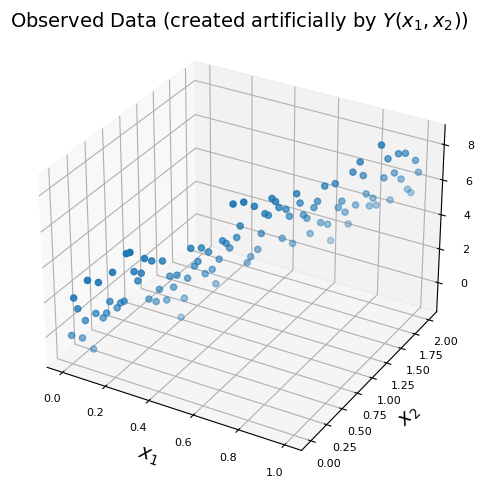

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fontsize=14
labelsize=8
title='Observed Data (created artificially by ' + r'$Y(x_1,x_2)$)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
#fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

Now let's see if our model will correctly predict the values for our unknown parameters, namely $b_0$, $b_1$, $b_2$ and $\sigma$.

#### Defining the Problem

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma^2 = 10$)

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   

<a id=model></a>


#### Defining a Model in PyMC3

In [13]:
with pm.Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters. P(theta)

    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    betas = pm.Normal('betas', mu=0, sigma=10, shape=2) 
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # mu is what is called a deterministic random variable, which implies that its value is completely
    # determined by its parents’ values (betas and sigma in our case). 
    # There is no uncertainty in the variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is a special case of a stochastic variable that we call an observed stochastic.
    # It is identical to a standard stochastic, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this variable were observed, 
    # and should not be changed by any fitting algorithm applied to the model. 
    # The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

**Note**: If our problem was a classification for which we would use Logistic regression see [below](#LR) <BR>
    
**Python Note**: `pm.Model` is designed as a simple API that abstracts away the details of the inference. For the use of `with` see [Compounds statements in Python.](https://docs.python.org/3/reference/compound_stmts.html).

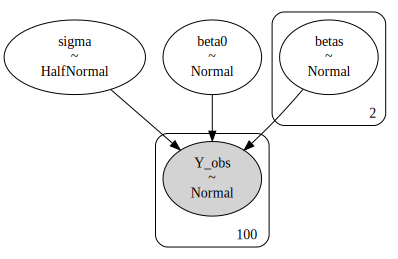

In [14]:
## do not worry about this, it's just a nice graph to have
## you need to install python-graphviz first
# conda install -c conda-forge python-graphviz
pm.model_to_graphviz(my_linear_model)

#### Fitting the Model with Sampling - Doing Inference

See below for PyMC3's sampling method. As you can see it has quite a few parameters. Most of them are set to default values by the package. For some, it's useful to set your own values.
```
pymc3.sampling.sample(draws=500, step=None, n_init=200000, chains=None, 
                      cores=None, tune=500, random_seed=None)
```

Parameters to set:

- **draws**: (int): Number of samples to keep when drawing, defaults to 500. Number starts after the tuning has ended. 
- **tune**: (int): Number of iterations to use for tuning the model, also called the burn-in period, defaults to 500. Samples from the tuning period will be discarded.
- **target_accept** (float in $[0, 1]$). The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
- (optional) **chains** (int) number of chains to run in parallel, defaults to the number of CPUs in the system, but at most 4.

`pm.sample` returns a `pymc3.backends.base.MultiTrace` object that contains the samples. We usually name it a variation of the word `trace`. All the information about the posterior is in `trace`, which also provides statistics about the sampler.

#### How does a good trace plot look like? Is this a good one?

<img src="
images/trace.png" width="700px">

In [17]:
## uncomment this to see more about pm.sample
help(pm.sample)

Help on function sample in module pymc.sampling.mcmc:

sample(draws: int = 1000, *, tune: int = 1000, chains: Optional[int] = None, cores: Optional[int] = None, random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None, progressbar: bool = True, step=None, nuts_sampler: str = 'pymc', initvals: Union[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]], Sequence[Optional[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]]]], NoneType] = None, init: str = 'auto', jitter_max_retries: int = 10, n_init: int = 200000, trace: Optional[pymc.backends.base.BaseTrace] = None, discard_tuned_samples: bool = True, compute_convergence_checks: bool = True, keep_warning_stat: bool = False, return_inferencedata: bool = True, idata_kwargs: Optional[Dict[str, Any]] = None, nuts_sampler_kwargs: Optional[Dict[str, Any]] = 

In [14]:
#help(pm.backends.base.MultiTrace)

In [39]:
with my_linear_model:
 
    print(f'Starting MCMC process')
    # draw nsamples posterior samples and run the default number of chains = 4 
    nsamples = 1000 # number of samples to keep
    burnin = 100 # burnin period
    trace1 = pm.sample(nsamples, tune=burnin, target_accept=0.8)
    trace2 = pm.sample(nsamples, tune=burnin, target_accept=0.8, return_inferencedata=False)
    print(f'DONE')

Starting MCMC process


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betas, sigma]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betas, sigma]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


DONE


In [52]:
var_names = trace2.varnames
var_names = var_names.remove('sigma_log__')
var_names
# also removed "sigma_log__" in trace2.varnames as trace2.varnames is a list
# !!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!

#### Model Plotting

PyMC3 provides a variety of visualizations via plots: [https://docs.pymc.io/api/plots.html](https://docs.pymc.io/api/plots.html). `arviz` is another library that you can use.

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


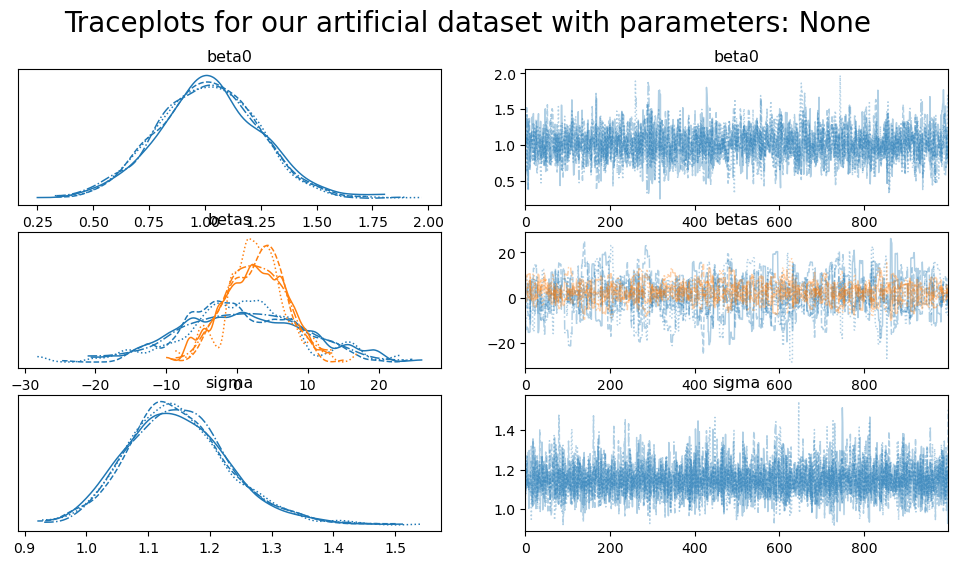

In [24]:
title = f'Traceplots for our artificial dataset with parameters: {var_names}'
pm.plot_trace(trace1);
plt.suptitle(
    title,
    fontsize=20
)
plt.show()

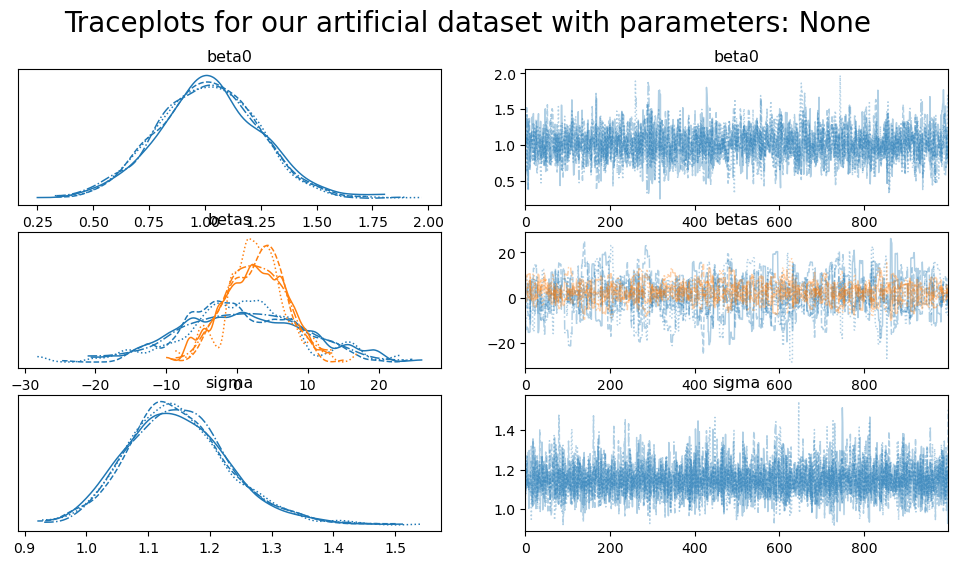

In [25]:
az.plot_trace(trace1, var_names=var_names);
plt.suptitle(
    title,
    fontsize=20
)
plt.show()

In [26]:
# generate results table from trace samples
# remember our true hidden values sigma = 1, beta0 = 1, beta = [1, 2.5] 
# We want R_hat < 1.1
results = az.summary(
    trace1, 
    var_names=var_names
)
display(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.015,0.229,0.580,1.438,0.005,0.004,2285.0,1858.0,1.0
betas[0],0.723,8.425,-15.344,16.104,0.381,0.281,486.0,512.0,1.0
betas[1],2.652,4.211,-5.220,10.513,0.190,0.141,487.0,507.0,1.0
sigma,1.149,0.084,0.986,1.302,0.001,0.001,4898.0,2731.0,1.0


In [20]:
#help(pm.Normal)

$\hat{R}$ is a metric for comparing how well a chain has converged to the equilibrium distribution by comparing its behavior to other randomly initialized Markov chains. Multiple chains initialized from different initial conditions should give similar results.
If all chains converge to the same equilibrium, $\hat{R}$ will be 1. If the chains have not converged to a common distribution, $\hat{R}$ will be > 1.01. $\hat{R}$ is a necessary but not sufficient condition.

For details on the $\hat{R}$ see *Gelman and Rubin (1992)*. 

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

<a id=2></a> [Top](#top)

## 2. Hierarchical Models


**Gelman et al.**'s famous radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in counties in several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we'll investigate this differences and try to make predictions of radonlevels in different county's based on the county itself and the presence of a basement. We’ll look at Minnesota, a state that contains **85** counties in which different measurements are taken, ranging from **2 to 116** measurements.

<img src="images/radon_house.jpg"  align="left">
<img src="images/MN.png" width="400" align="center">

In [43]:
df = pd.read_csv('../data/radon.csv', index_col=[0])
df['log_radon'] = df['log_radon'].astype('float')
county_names = df.county.unique()
county_idx = df.county_code.values
n_counties = len(df.county.unique())

df.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,,2,4.0,41,930.0,930.0,12088.0,12288.0,2.2,9.7,1146.499,1.0,0.0,1.0,AITKIN,27001.0,0.502,0,0.833
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,5,2.0,40,1615.0,1615.0,11888.0,12088.0,2.2,14.5,471.366,0.0,0.0,1.0,AITKIN,27001.0,0.502,0,0.833
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,3,2.0,42,1030.0,1515.0,20288.0,21188.0,2.9,9.6,433.317,0.0,0.0,1.0,AITKIN,27001.0,0.502,0,1.099
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,,2,2.0,24,1410.0,1410.0,122987.0,123187.0,1.0,24.3,461.624,0.0,0.0,1.0,AITKIN,27001.0,0.502,0,0.095
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,,3,2.0,40,600.0,600.0,12888.0,13088.0,3.1,13.8,433.317,0.0,0.0,3.0,ANOKA,27003.0,0.429,1,1.163


In [45]:
df.shape

(919, 29)

Each **row** in the dataframe represents the radon measurements for **one house** in a specific county including whether the house has a basement (floor = 0) or not (floor = 1). We are interested in whether having a basement increases the radon measured in the house.

To keep things simple let's keep only the following three variables: `county`, `log_radon`, and `floor`

Let's check how many different counties we have. We also notice that they have a different number of houses. Some have a large number of houses measured, some only 1.

In [49]:
print(f'We have {n_counties} counties in {len(df.state.value_counts())} state.')
df['county'].value_counts().head(5)

We have 85 counties in 1 state.


ST LOUIS      116
HENNEPIN      105
DAKOTA         63
ANOKA          52
WASHINGTON     46
Name: county, dtype: int64

In [47]:
# keep only these variables
data = df[['county', 'log_radon', 'floor']]
data.head()

,county,log_radon,floor
0,AITKIN,0.833,1.0
1,AITKIN,0.833,0.0
2,AITKIN,1.099,0.0
3,AITKIN,0.095,0.0
4,ANOKA,1.163,0.0


In [48]:
data['county'].value_counts()[-5:]

MILLE LACS         2
YELLOW MEDICINE    2
MAHNOMEN           1
WILKIN             1
MURRAY             1
Name: county, dtype: int64

### Pooling: Same Linear Regression for all

We can just pool all the data and estimate one big regression to asses the influence of having a basement on radon levels across all counties. Our model would be:

\begin{equation}
y_{i} = \alpha + \beta*floor_{i} 
\end{equation}

Where $i$ represents the measurement (house), and floor contains a 0 or 1 if the house has a basement or not. By ignoring the county feature, we do not differenciate on counties.

In [50]:
with pm.Model() as pooled_model:
    # common priors for all
    a = pm.Normal('a', mu=0, sigma=100)   
    b = pm.Normal('b', mu=0, sigma=100)

    # radon estimate
    radon_est = a + b*data['floor'].values

    # likelihood after radon observations
    radon_obs = pm.Normal('radon_obs', mu=radon_est,  
                           observed=data['log_radon']) # note here we enter the whole dataset

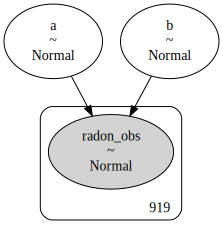

In [51]:
pm.model_to_graphviz(pooled_model)

In [59]:
with pooled_model:
 
    pooled_trace = pm.sample(2000, tune=1000, target_accept=0.9)
    pooled_trace_ = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=False)
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


DONE


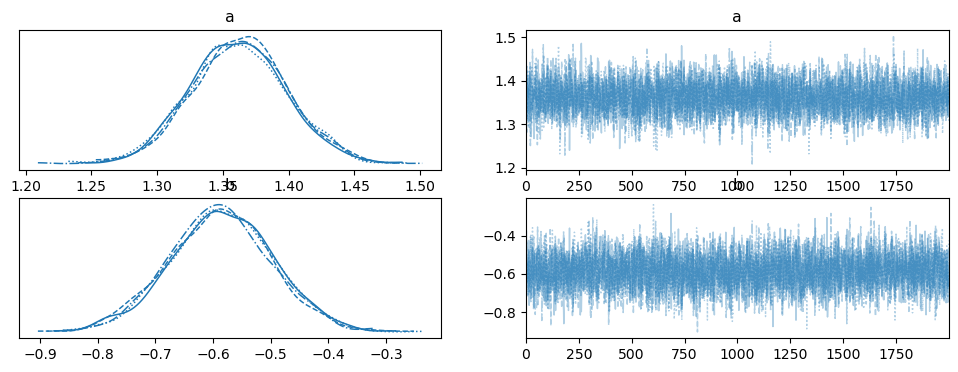

In [54]:
pm.plot_trace(pooled_trace);

Remember, with the pooled model we have only one intercept, $\alpha$, and only one slope, $\beta$ for all the counties. Let's plot the regression lines.

In [57]:
data['county'].value_counts()

ST LOUIS             116
HENNEPIN             105
DAKOTA                63
ANOKA                 52
WASHINGTON            46
RAMSEY                32
STEARNS               25
OLMSTED               23
CLAY                  14
ROSEAU                14
BLUE EARTH            14
GOODHUE               14
SCOTT                 13
MCLEOD                13
WINONA                13
MOWER                 13
WRIGHT                13
CROW WING             12
RICE                  11
ITASCA                11
STEELE                10
CARLTON               10
DOUGLAS                9
LAKE                   9
FREEBORN               9
MORRISON               9
MARSHALL               9
LYON                   8
SHERBURNE              8
OTTER TAIL             8
KOOCHICHING            7
BELTRAMI               7
WABASHA                7
MARTIN                 7
HOUSTON                6
PINE                   6
FARIBAULT              6
CARVER                 6
CHISAGO                6
CASS                   5


In [55]:
# plot just a subset of the countries, the five most counted and the 5 less counted
counties_by_counts = data['county'].value_counts()
counties = counties_by_counts.index[:5].tolist() + counties_by_counts.index[75:-5].tolist() 
counties

['ST LOUIS',
 'HENNEPIN',
 'DAKOTA',
 'ANOKA',
 'WASHINGTON',
 'STEVENS',
 'LAC QUI PARLE',
 'COOK',
 'ROCK',
 'POPE']

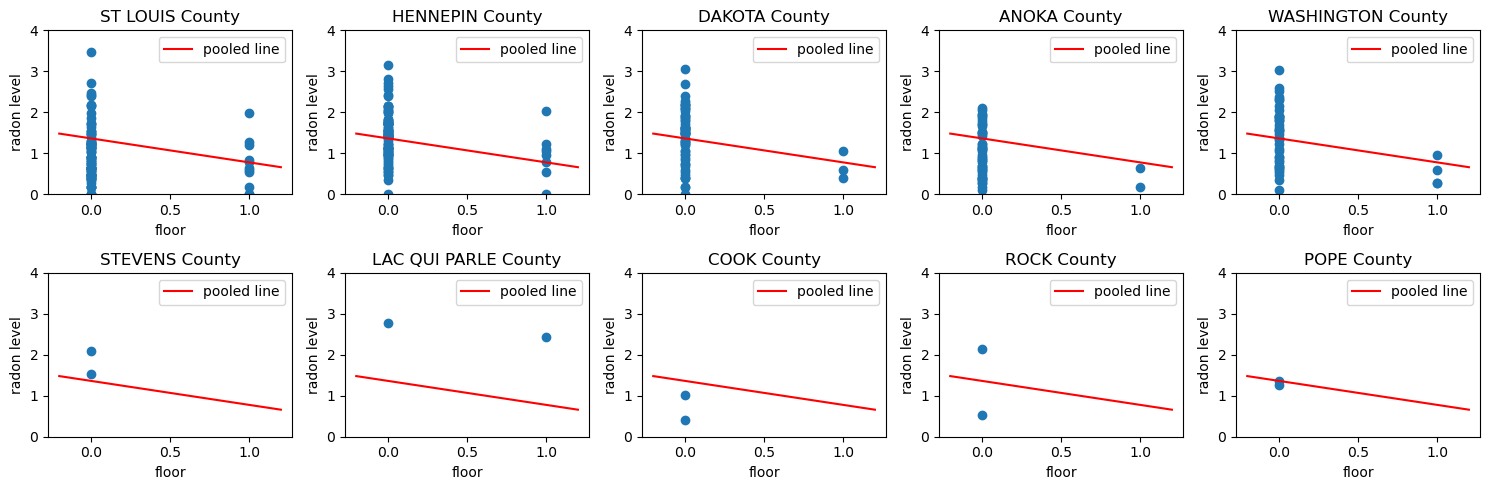

In [60]:
# plot just a subset of the countries
#counties = ['HENNEPIN','AITKIN','WASHINGTON', 'MURRAY', 'YELLOW MEDICINE', 'MAHNOMEN']

plt.figure(figsize=(15,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    x = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace_['a'].mean() + pooled_trace_['b'].mean()*x
    subplt = plt.subplot(gs[i])

    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(x, radon_est, c='r', label='pooled line');
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

### Unpooling: Separate Linear Regression for each county 

We believe that different counties have different relationships of radon and basements. Our model would be:

\begin{equation}
\textbf{radon}_{i,c} = \alpha_c + \beta_c*\textbf{floor}_{i,c} 
\end{equation}

Where $\textbf{i}$ represents the measurement, $\textbf{c}$ the county, and floor contains a 0 or 1 if the house has a basement or not. 

Notice we have separate coefficients for each county in $a_c$ and $b_c$. They are totally different, they could even come from different distributions.

We will do this for **only one county**, since this is very time consuming, as an example.  

In [65]:
# chose a county
county = 'WASHINGTON'
county_data = data.loc[data['county']==county]
county_data

,county,log_radon,floor
841,WASHINGTON,2.332,0.0
842,WASHINGTON,2.054,0.0
843,WASHINGTON,0.833,0.0
844,WASHINGTON,1.887,0.0
845,WASHINGTON,2.510,0.0
846,WASHINGTON,1.548,0.0
847,WASHINGTON,1.841,0.0
848,WASHINGTON,1.887,0.0
849,WASHINGTON,1.065,0.0
850,WASHINGTON,0.693,0.0


In [33]:
#help(pm.Normal)

In [66]:
with pm.Model() as unpooled_model:
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a)   
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b)

    radon_est = a + b*county_data['floor'].values

    radon_obs = pm.Normal('radon_like', mu=radon_est,  
                           observed=county_data['log_radon']) 

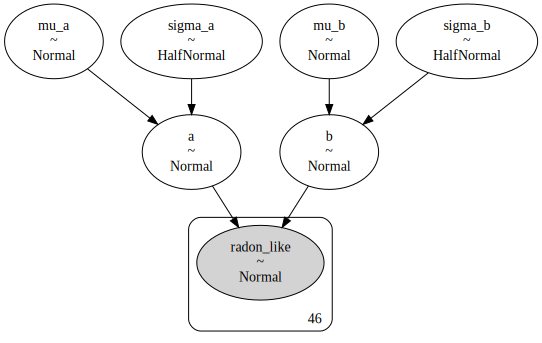

In [67]:
pm.model_to_graphviz(unpooled_model)

In [68]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, tune=1000, target_accept=0.99) 
    unpooled_trace_ = pm.sample(5000, tune=1000, target_accept=0.99, return_inferencedata=False) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 59 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 728 divergences after tuning. Increase `target_accept` or reparameterize.


DONE


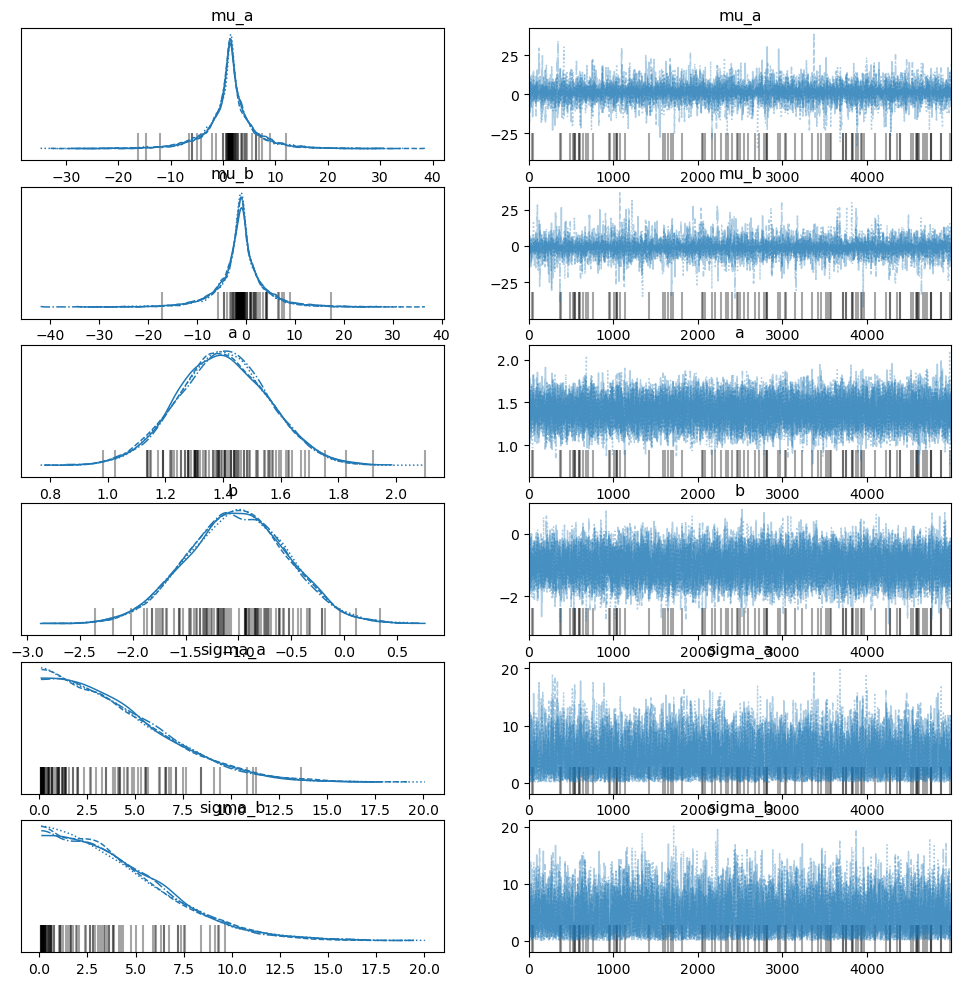

In [69]:
pm.plot_trace(unpooled_trace);
# If divergences data is available in sample_stats, will plot the location of divergences as dashed vertical lines.
# divergences" refers to the identification of problematic samples during the sampling process of a Bayesian inference method called Hamiltonian Monte Carlo (HMC).

Print the regression line for our chosen county alone.

46


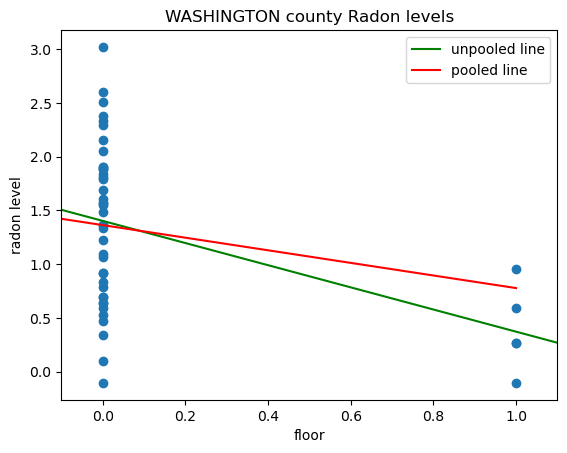

In [70]:
county_data = data.loc[data['county']==county]
print(len(county_data))

x = np.linspace(-0.2, 1.2) 
radon_est_unpooled = unpooled_trace_['a'].mean() + unpooled_trace_['b'].mean()*x 

xx = np.linspace(-0.2, 1.)    
radon_est_pooled = pooled_trace_['a'].mean() + pooled_trace_['b'].mean()*xx

plt.scatter(county_data['floor'], county_data['log_radon'])
plt.xlim(-0.1,1.1)
plt.xlabel('floor', fontsize=10)
plt.ylabel('radon level', fontsize=10)
plt.title(f'{str(county)} county Radon levels')
plt.plot(x, radon_est_unpooled, c='g', label='unpooled line');
plt.plot(xx, radon_est_pooled, c='r', label='pooled line');
plt.legend();

### Partial pooling: Hierarchical Regression (Varying-Coefficients Model)

Counties, of course, have similarities, so there is a middle ground to both of these extremes. Specifically, we may assume that while $\alpha_c$ and $\beta_c$are different for each county as in the unpooled case, the coefficients are all drawn from the same distribution:

\begin{equation}
radon_{i,c} = \alpha_c + \beta_c*floor_{i,c} 
\end{equation}   

\begin{equation}
a_c \sim  \mathcal{N}(\mu_a,\,\sigma_a^{2})
\end{equation} 
\begin{equation}
b_c \sim  \mathcal{N}(\mu_b,\,\sigma_b^{2})
\end{equation}

where the common parameters are:
\begin{eqnarray}
\mu_a \sim  \mathcal{N}(0,\,10) \\
\sigma_a^2 \sim  |\mathcal{N}(0,\,10)| \\
\mu_b \sim  \mathcal{N}(0,\,10) \\
\sigma_b^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}

The different counties are effectively sharing information through the common priors. We are thus observing what is known as shrinkage; modeling the groups not as independent from each other, neither as a single group but rather as related.

<div class="discussion"><b>Discussion:</b> how can we best handle this data? Does it make sense to make inferences without taking into account the county?</div>

#### TALKING POINTS

We saw that some counties had only one sample, so if that house is a really old with old lead pipes, our prediction will be that all houses in this county have radon. On the other extreme, if we have a newer house with no radon then again we will have missleading results. In one case, you will overestimate the bad quality and in the other underestimate it. Under a hierarchical model, the miss-estimation of one group will be offset by the information provided by the other groups. As always, gathering more data helps, if this is an option.

In [71]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # beta for each county, distributed around group mean mu_b
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    #eps = pm.HalfCauchy('eps', 5.)

    radon_est = a[county_idx] + b[county_idx]*data['floor'].values

    # Data likelihood with sigma for random error
#     radon_like = pm.Normal('radon_like', mu=radon_est,
#                            sigma=eps, observed=data['log_radon'])

    # Data likelihood with sigma without random error
    radon_like = pm.Normal('radon_like', mu=radon_est, #sigma=eps, 
                           observed=data['log_radon'])

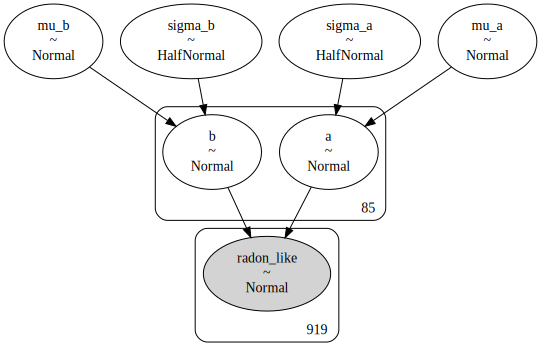

In [72]:
# uncomment to create graph
pm.model_to_graphviz(hierarchical_model)

#### Inference 

In [73]:
%%time
with hierarchical_model:
    hierarchical_trace = pm.sample(10000, tune=5000, target_accept=.9, chains=2)
    hierarchical_trace_ = pm.sample(10000, tune=5000, target_accept=.9, return_inferencedata=False, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 96 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 82 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


CPU times: user 14.5 s, sys: 789 ms, total: 15.3 s
Wall time: 3min 5s


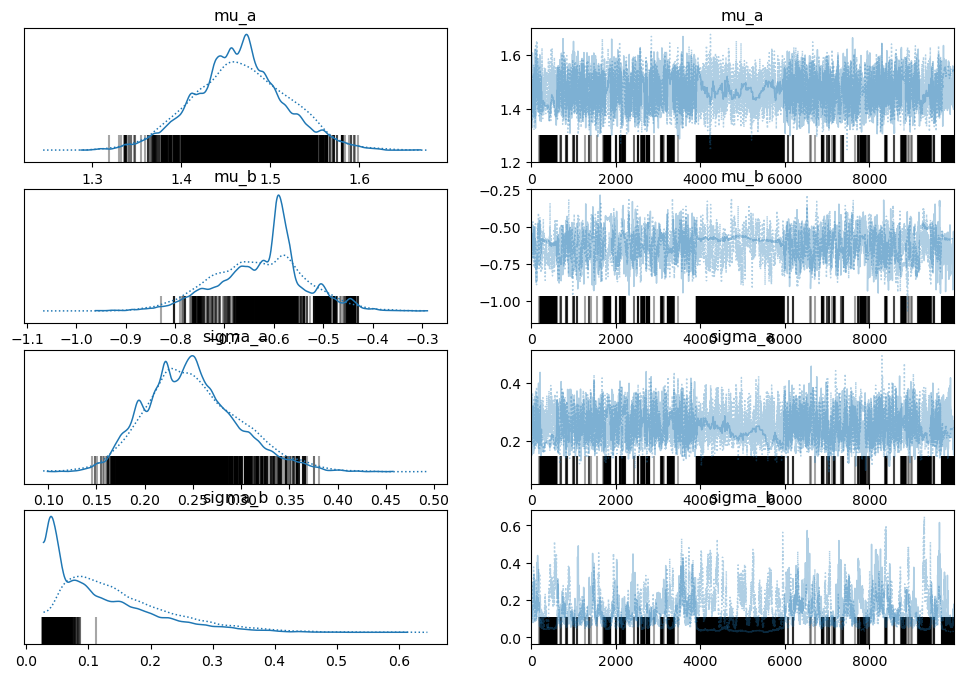

In [74]:
pm.plot_trace(hierarchical_trace, var_names=['mu_a', 'mu_b',
                                            'sigma_a', 'sigma_b']);

In [75]:
results = pm.summary(hierarchical_trace) 

In [76]:
results[:20] # printing only 20 of them

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,1.465,0.053,1.367,1.565,0.002,0.001,888.0,4491.0,1.00
mu_b,-0.626,0.092,-0.792,-0.443,0.004,0.003,678.0,716.0,1.01
a[0],1.342,0.228,0.902,1.754,0.011,0.007,460.0,1585.0,1.00
a[1],1.065,0.131,0.818,1.299,0.009,0.006,226.0,1147.0,1.01
a[2],1.456,0.228,1.049,1.902,0.007,0.005,951.0,5961.0,1.00
a[3],1.502,0.204,1.121,1.887,0.006,0.004,1100.0,7973.0,1.00
a[4],1.463,0.217,1.054,1.881,0.006,0.004,1248.0,1672.0,1.00
a[5],1.463,0.222,1.030,1.882,0.006,0.004,1291.0,6590.0,1.01
a[6],1.705,0.198,1.302,2.058,0.010,0.007,359.0,206.0,1.01
a[7],1.590,0.238,1.153,2.016,0.017,0.012,202.0,501.0,1.01


In [77]:
counties

['ST LOUIS',
 'HENNEPIN',
 'DAKOTA',
 'ANOKA',
 'WASHINGTON',
 'STEVENS',
 'LAC QUI PARLE',
 'COOK',
 'ROCK',
 'POPE']

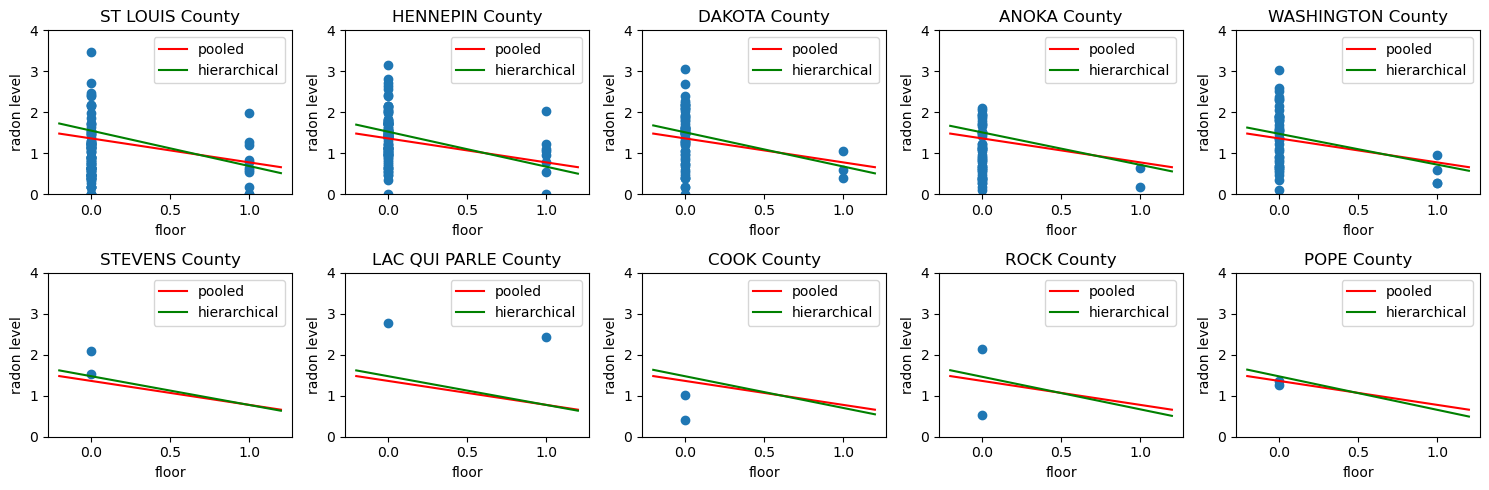

In [78]:
# use counties from before or choose new ones
#counties = ['HENNEPIN','AITKIN','WASHINGTON', 'LAKE OF THE WOODS', 'YELLOW MEDICINE', 'ANOKA']
#counties = ['HENNEPIN', 'DAKOTA', 'ANOKA', 'WILKIN', 'MURRAY']

plt.figure(figsize=(15,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    if county_data.shape[0]==1: break;
    subplt = plt.subplot(gs[i])
    
    # pooled line (single values coeff for all)
    xx = np.linspace(-0.2, 1.2)    
    radon_est = pooled_trace_['a'].mean() + pooled_trace_['b'].mean()*xx
    
    radon_est_hier = np.mean(hierarchical_trace_['a'][i]) + \
                      np.mean(hierarchical_trace_['b'][i])*xx
    
    # hierarchical line
    subplt.set_ylim(0.,4.)
    subplt.scatter(county_data['floor'], county_data['log_radon'])
    subplt.plot(xx, radon_est, c='r', label='pooled');
    
    # plot the hierarchical, varying coefficient model
    subplt.plot(xx, radon_est_hier, c='g', label='hierarchical');
    
    subplt.set_xlabel('floor', fontsize=10)
    subplt.set_ylabel('radon level', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()
    plt.tight_layout()

*Adapted from PyMC3 docs: https://docs.pymc.io/notebooks/GLM-hierarchical.html*

## Appendix A: Is this a fair coin?

### Can we find out if this a fair coin without using sampling?

Let's say you visit the casino. You want to test your theory that casinos are dubious places where coins have been manipulated to have a larger probability for tails. So you will try to estimate how fair a coin is based on a certain amount of  flips. You have no prior opinion on the coin's fairness (i.e. **what $\theta$ might be**), and begin flipping the coin. You get either Heads ($H$) or Tails ($T$) as our observed data and want to see if your posterior probabilities change as you obtain more data, that is, more coin flips. A nice way to visualize this is to plot the posterior probabilities as we observe more data. Your data is the pair ($n,k$) where $n$ is the number of flips and $k$ is the number of successes. 

We will be using Bayes rule. $\textbf{D}$ is our data. <BR><BR>

<div style="font-size:120%; font-color:#b3e6ff; text-align: center">Posterior $\propto$ Prior $\times$ Likelihood</div>

\begin{equation}
P(\theta|\textbf{D}) \propto P(\theta) \times P(\textbf{D} |\theta)  
\end{equation}
    
**a)** Let's say we believe that our experiment is governed by a $\text{Binomial}$ distribution (this will be our Likelihood).

\begin{equation}
P(\theta|\textbf{D}) \propto \text{Beta(a,b)} \times \text{Binomial}(\textbf{k},\textbf{n}|\theta)  
\end{equation}
    
**b)** We start with a non-informative prior, a $\text{Beta}$ distribution with (a=b=1.)
    
\begin{equation}
P(\theta|1.,1.) = \text{Beta(1., 1.)} 
\end{equation}
    
**c)** We enter the data as pairs of ($\textbf{k},\textbf{n}$) (we observe $\textbf{k}$ heads in $\textbf{n}$ tosses), and we update our Beta with new a,b as follows $^*$: 

\begin{equation}
P(\theta|\textbf{k}) = Beta(\alpha + \textbf{k}, \beta + (n - \textbf{k})) 
\end{equation}

**d)** We are done! That is why using a congugate prior helps you find your parameters analytically.
    
$^*$ *(the proof for this formula is beyond our scope, if interested, see this [Wikipedia article](https://en.wikipedia.org/wiki/Conjugate_prior#Example))*





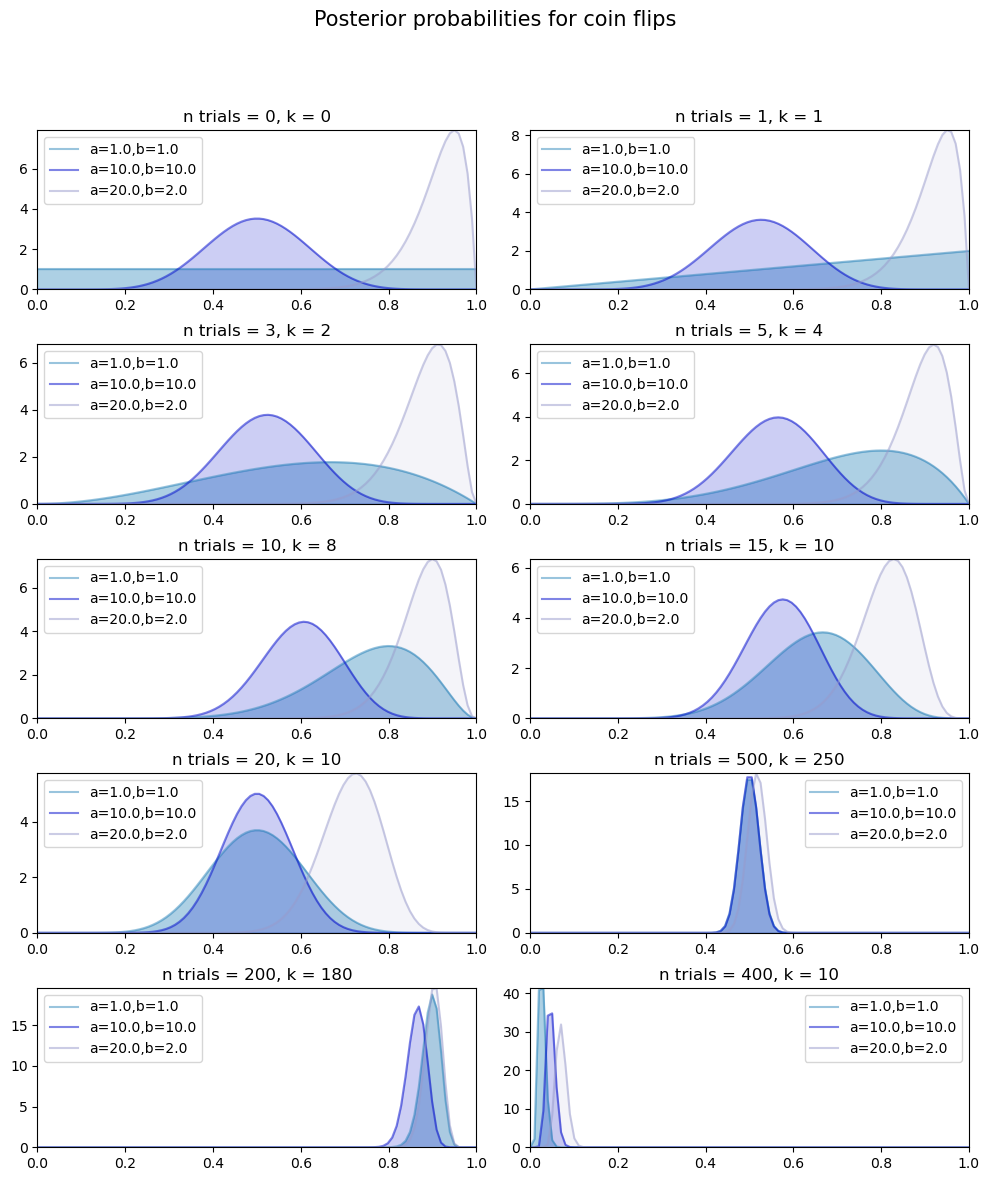

In [80]:
# change the data
trials = np.array([0, 1, 3, 5, 10, 15, 20, 500, 200, 400])
heads = np.array( [0, 1, 2, 4, 8,  10, 10, 250, 180, 10])

# non-informative prior Beta(a,b=1), shows our ignorance about the coin
# informative prior Beta(a,b=10.), shows our belief that this is a fair coin
# informative prior Beta(a=20.,b=2.), shows our belief that this is NOT a fair coin
alphas = [1., 10., 20.]
betas = [1., 10., 2.]
colors = ['#348ABD', '#000BCC', '#999BCC']
opacity = [0.4, 0.2, 0.1]

plt.figure(figsize=(10,12))
x = np.linspace(0, 1, 100)
for k, N in enumerate(trials):
    sublabel=f'n trials = {trials[k]}, k = {heads[k]}'
    sx = plt.subplot(int(len(trials)/2), 2, k+1)
    for i in range(len(alphas)):
        posterior = stats.beta.pdf(x, alphas[i] + heads[k], betas[i] + trials[k] - heads[k])
        plt.plot(x, posterior, alpha = 0.5, c=colors[i], label=f'a={alphas[i]},b={betas[i]}');
        plt.fill_between(x, 0, posterior, color=colors[i], alpha=opacity[i]) 
        plt.legend(loc='upper left', fontsize=10)
        plt.title(sublabel)
    plt.legend()
    plt.autoscale(tight=True)
    
plt.suptitle("Posterior probabilities for coin flips", fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.88)

## Appendix B: MAP

#### Fitting the Model with MAP (FYI, we will not directly use this method)

In Bayesian analysis we have our **prior(s)**, we define our **likelihood**, and, having specified our **model**, we try to calculate posterior estimates for the unknown variables in the model. We could try to calculate the posterior estimates analytically, but for most the models, this is not feasible. What we do then is compute summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods. 

\begin{equation}
P(\theta|\textbf{D}) \rightarrow  \{\theta_1,....\theta_n\}
\end{equation}

Then we can find any estimate we want by using these samples, for example:

\begin{equation}
\mathbb{E}[f(\theta] = \int d\theta{p(\theta) f(\theta)} 
\end{equation}

So we calculate the maximum a posteriori **(MAP)** point using optimization methods.

\begin{equation}
f(\hat{\theta}), \hat{\theta} = argmax ({p(\theta))} 
\end{equation}

The maximum a posteriori **(MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function. 

**MAP estimate** is not always reasonable, especially if the mode is at an extreme or we have a multimodal distribution, or we have high dimensional posteriors. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the variance parameter for the group means is almost zero. Most techniques for finding the MAP estimate only find a local optimium (which is often good enough), and can therefore fail badly for multimodal posteriors, as mentioned above.

To solve these issues we turn to sampling as our method for finding the posterior.

You do not have to worry about **MAP** in our problems. Our pyMC3 models use the MAP method to initialize the variables under the hood and we do not have to explicitly set this. 

In the case where the variance parameter for the group means is almost zero, the posterior distribution can have near infinite density. This occurs because the model assigns almost all of the probability mass to a very narrow range of parameter values, specifically a very small range of values for the group means.

This situation arises because the data suggest that the group means are tightly clustered around a single value, with very little variation. Since the model assumes a non-zero variance parameter, the near-zero value for the variance is considered extremely unlikely given the observed data. As a result, the posterior assigns an extremely high density to parameter values close to zero variance.

**References**:

- *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55* [(https://doi.org/10.7717/peerj-cs.55)](https://doi.org/10.7717/peerj-cs.55)
- [Distributions in PyMC3](https://docs.pymc.io/api/distributions.html)
- [More Details on Distributions](https://docs.pymc.io/developer_guide.html)

Information about PyMC3 functions including descriptions of distributions, sampling methods, and other functions, is available via the `help` command.